# Mittelstufenprojekt: Vorhersagen von einzelnen Rossmann Umsätzen

Rossmann betreibt über 4.500 Drogeriemärkte in sieben europäischen Ländern. Bis 2015 etwa müssen die Filialleiter von Rossmann ihre täglichen Umsätze bis zu sechs Wochen im Voraus prognostizieren. Die Umsätze in den Filialen werden von vielen Faktoren beeinflusst, wie z. B. Werbeaktionen, Wettbewerb, Schulferien und Feiertage, Saisonabhängigkeit und örtliche Gegebenheiten. Bei Tausenden von Managern, die ihre Umsätze auf der Grundlage ihrer individuellen Gegebenheiten vorhersagen, kann die Genauigkeit der Ergebnisse sehr unterschiedlich sein.

In [123]:
# Basic Functionalities
import time
from pprint import pprint
from tqdm import tqdm
# Working with Data
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Models
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

## 1. Data Preparation

In [124]:
train = pd.read_csv('input-rss/train.csv')
store = pd.read_csv('input-rss/store.csv')
test = pd.read_csv('input-rss/test.csv')

/var/folders/_y/hzd68ny17rsfgx2sq7wtmxcw0000gn/T/ipykernel_993/271173482.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('input-rss/train.csv')


In [125]:
print(store.info()) 
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dty

### 1.1 Überlegungen zu den Datensätzen
1.1.1 Store
- CompetitionDistance (3 null) mit durchschnitt eintragen
- CompetitionOpenSinceMonth -> gelöscht
- CompetitionOpenSinceYear -> gelöscht
- Promo2 -> 0: kein Promo2, 
            1: Promo2 aktiv -> Promo2SinceWeek, Promo2SinceYear, PromoInterval

1.1.2 Train
- Date -> Datum; Änderung in Datetime bzw. Jahr, Monat, Tag, Woche, Tag im Jahr, Tag der Woche, Feiertag
- StateHoliday -> 0: kein Feiertag, a: Feiertag (Gesetzlich), b: Feiertag (Ostern), c: Feiertag (Christmas); Änderung in 0, 1, 2, 3
- SchoolHoliday -> 0: kein Schulferien, 1: Schulferien

### 1.2 Data Cleaning

In [126]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [127]:
store.drop(store.columns[[4,5]], axis=1, inplace=True)

In [128]:
# map strings to categorical values
store['StoreType'] = store['StoreType'].map({'a':0, 'b':1, 'c':2, 'd':3})
store['Assortment'] = store['Assortment'].map({'a':0, 'b':1, 'c':2})
store.head()

Store  StoreType  Assortment  CompetitionDistance  Promo2  Promo2SinceWeek  \
0      1          2           0               1270.0       0              NaN   
1      2          0           0                570.0       1             13.0   
2      3          0           0              14130.0       1             14.0   
3      4          2           2                620.0       0              NaN   
4      5          0           0              29910.0       0              NaN   

   Promo2SinceYear    PromoInterval  
0              NaN              NaN  
1           2010.0  Jan,Apr,Jul,Oct  
2           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN  
4              NaN              NaN

In [129]:
le = LabelEncoder()
store['PromoInterval'] = le.fit_transform(store['PromoInterval'].astype(str))
store['Promo2SinceWeek'] = le.fit_transform(store['Promo2SinceWeek'].astype(str))
store['Promo2SinceYear'] = le.fit_transform(store['Promo2SinceYear'].astype(str))

In [130]:
store.head()

Store  StoreType  Assortment  CompetitionDistance  Promo2  Promo2SinceWeek  \
0      1          2           0               1270.0       0               24   
1      2          0           0                570.0       1                2   
2      3          0           0              14130.0       1                3   
3      4          2           2                620.0       0               24   
4      5          0           0              29910.0       0               24   

   Promo2SinceYear  PromoInterval  
0                7              3  
1                1              1  
2                2              1  
3                7              3  
4                7              3

In [131]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [132]:
train['StateHoliday'] = le.fit_transform(train['StateHoliday'].astype(str))
print(train.head())

test['StateHoliday'] = le.fit_transform(test['StateHoliday'].astype(str))
test['Open'] = le.fit_transform(test['Open'].astype(str))
print(test.head())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1             0   
1      2          5  2015-07-31   6064        625     1      1             0   
2      3          5  2015-07-31   8314        821     1      1             0   
3      4          5  2015-07-31  13995       1498     1      1             0   
4      5          5  2015-07-31   4822        559     1      1             0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek        Date  Open  Promo  StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17     1      1             0              0
1   2      3          4  2015-09-17     1      1             0              0
2   3      7          4  2015-09-17     1      1             0              0
3   4      8          4  2015-09-17     1      1             0              0
4   5      9   

Feature Engineering: Date bei beiden in die Einzelteile aufteilen

In [133]:
# split date into year, month, day
train['Date'] = pd.to_datetime(train['Date'])
train['Date_Year'] = train['Date'].dt.year
train['Date_Month'] = train['Date'].dt.month
train['Date_Day'] = train['Date'].dt.day
train = train.drop('Date', axis=1)

# split date into year, month, day
test['Date'] = pd.to_datetime(test['Date'])
test['Date_Year'] = test['Date'].dt.year
test['Date_Month'] = test['Date'].dt.month
test['Date_Day'] = test['Date'].dt.day
test = test.drop('Date', axis=1)


In [134]:
print(train.head())
print(test.head())

   Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5   5263        555     1      1             0   
1      2          5   6064        625     1      1             0   
2      3          5   8314        821     1      1             0   
3      4          5  13995       1498     1      1             0   
4      5          5   4822        559     1      1             0   

   SchoolHoliday  Date_Year  Date_Month  Date_Day  
0              1       2015           7        31  
1              1       2015           7        31  
2              1       2015           7        31  
3              1       2015           7        31  
4              1       2015           7        31  
   Id  Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Date_Year  \
0   1      1          4     1      1             0              0       2015   
1   2      3          4     1      1             0              0       2015   
2   3      7          4     1      1   

In [135]:
# merge train and store assortments
#train = pd.merge(train, 
#                 store[['StoreType', 'Assortment', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear']],
#                 left_on='Store', 
#                 right_index=True)
#test = pd.merge(test, 
#                store[['StoreType', 'Assortment', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear']],
#                left_on='Store', 
#                right_index=True)

Nachdem ich hier die dataframes gemerged habe, fehlen im Test Datensatz 48 Einträge. Ich nehme den merge zurück, danach entspricht zwar der Test Datensatz nicht mehr den Vorbedingungen des Trainingsdatensatzes, aber ich kann damit eine Submission erstellen. Wahrscheinlich werde ich auch den merge aus dem Train Dataset rausnehmen, wobei das schon wichtig ist, um die Daten zu analysieren(?). Wenn diese Daten raus sind, ist das Ergebnis des gestackten Modells deutlich schlechter als im Vergleich mit dem Assortment, Promointerval und Promo2SinceWeek, Promo2SinceYear. Ich werde also die Daten nicht wieder reinnehmen, da ich keine Ahnung habe, wie ich die fehlenden 48 Einträge füllen soll. Diesen Kompromiss muss ich wohl eingehen.

In [136]:
print(train.describe())
print(test.describe())

              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  StateHoliday  SchoolHoliday     Date_Year    Date_Month  \
count  1.017209e+06  1.017209e+06   1.017209e+06  1.017209e+06  1.017209e+06   
mean   3.815145e-01  4.516279e-02   1.786467e-01  2.013832e+03  5.846762e+00   
std    4.857586e-01  2.836559e-01   3.830564e-01

## 2. Exploratory Data Analysis

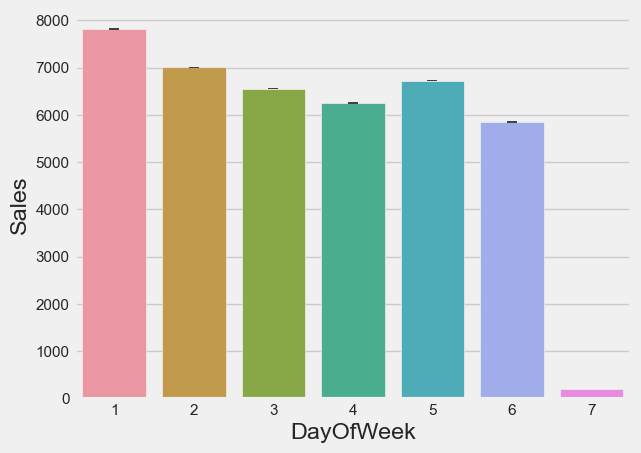

In [137]:
sns.barplot(x='DayOfWeek', y='Sales', data=train)
plt.show()

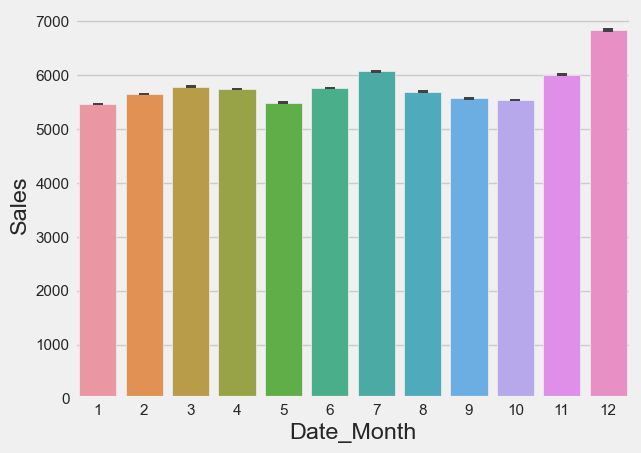

In [138]:
sns.barplot(x='Date_Month', y='Sales', data=train)
plt.show()

-> Die Umsätze sind im Dezember und Juli durschnittlich höher als im Rest des Jahres.

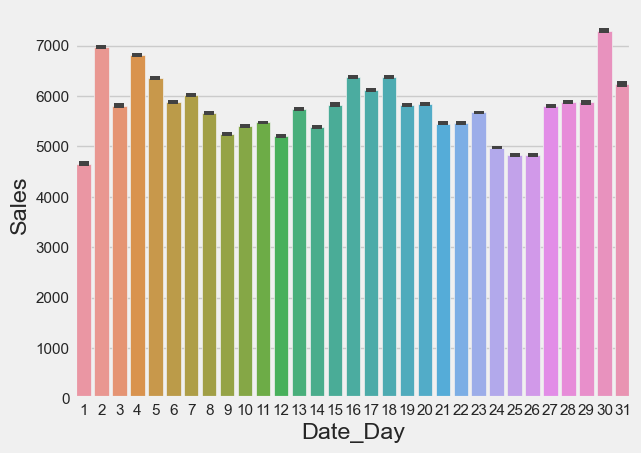

In [139]:
sns.barplot(x='Date_Day', y='Sales', data=train)
plt.show()

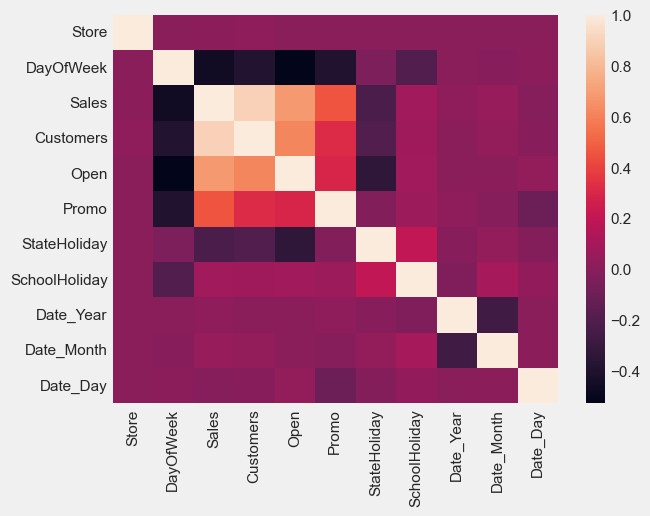

In [140]:
corr = train.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

<AxesSubplot: >

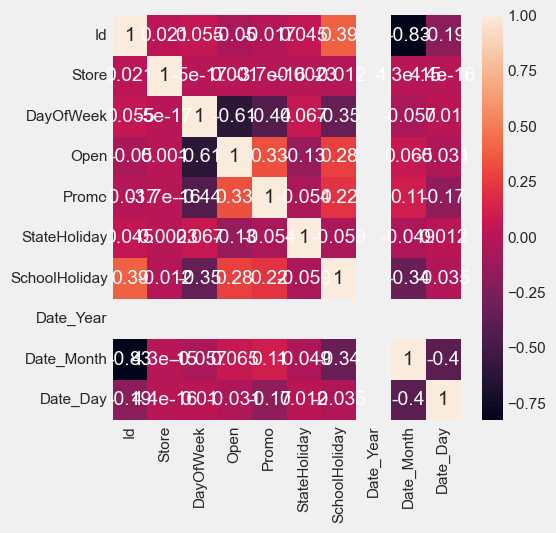

In [141]:
plt.figure(figsize=(5,5))
sns.heatmap(test.corr(),annot=True)

<AxesSubplot: >

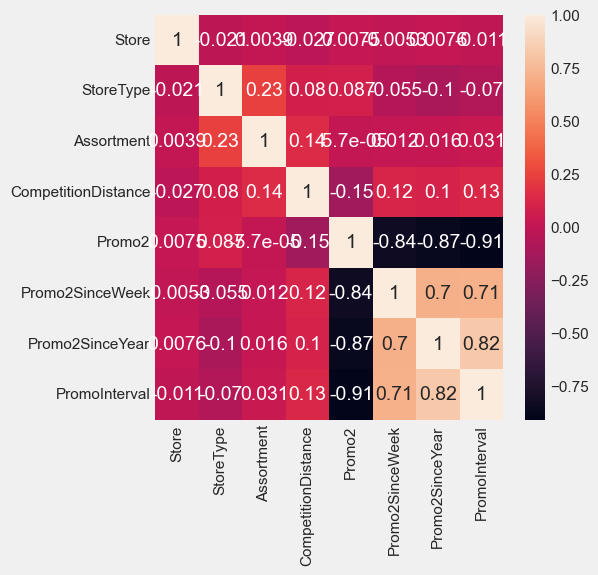

In [142]:
plt.figure(figsize=(5,5))
sns.heatmap(store.corr(),annot=True)

> Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday haben eine hohe bis mäßig positive Korrelation mit Sales.

> Der Wochentag korreliert negativ mit Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday.

## 3. Modelling

scaling notwendig? -> nein, vielleicht bei kNN oder SVM / XGB, doch da werden die Kennzahlen (RMSE und Average Error) wesentlich schlechter
```X = train.drop(['Sales', 'Customers'], axis=1)
y = train['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

In [143]:
train.drop(['Customers'], axis=1, inplace=True) # Customers is not in test set

In [144]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Sales'], axis=1),
                                                    train['Sales'],
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(813767, 9)
(203442, 9)
(813767,)
(203442,)


In [145]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    
    print('Average Error: {:0.4f} degrees'.format(np.mean(errors)))
    print('RMSE = {:0.2f}'.format(np.sqrt(mean_squared_error(test_labels, predictions))))


def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print('Training set score: {:.2f}'.format(model.score(X_train, y_train)))
    print('Test set score: {:.2f}'.format(model.score(X_test, y_test)))
    evaluate(model, X_test, y_test)
    
    return model

In [146]:
# defining a function to plot feature importance
def plot_feature_importance(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

### 3.1 k-Nearest Neighbors

In [64]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [65]:
knn_scaled = KNeighborsRegressor(n_neighbors=3)
knn_scaled = train_evaluate(knn_scaled, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Training set score: 0.73
Test set score: 0.46
Average Error: 0.4856 degrees
RMSE = 0.73


In [66]:
knn = KNeighborsRegressor(n_neighbors=3)
knn = train_evaluate(knn, X_train, y_train, X_test, y_test)

Training set score: 0.81
Test set score: 0.70
Average Error: 1414.4802 degrees
RMSE = 2122.29


Mit skalierten Daten ist die Performance des KNN eindeutig geringer, als das Training mit unskalierten Daten.

Nico's KNN hatte einen etwas besseren Wert: 
```
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(x_train, y_train)
print(knn.score(x_test, y_test))

>>> 0.9003273363217383
```
0.9003273363217383 - 0.82 = ~0.08

### 3.2 Logistic Regression

In [67]:
lr = LinearRegression()
lr = train_evaluate(lr, X_train, y_train, X_test, y_test)

Training set score: 0.54
Test set score: 0.54
Average Error: 1770.6203 degrees
RMSE = 2614.55


### 3.3 Random Forest

Training set score: 0.96
Test set score: 0.81
Average Error: 918.4684 degrees
RMSE = 1664.91


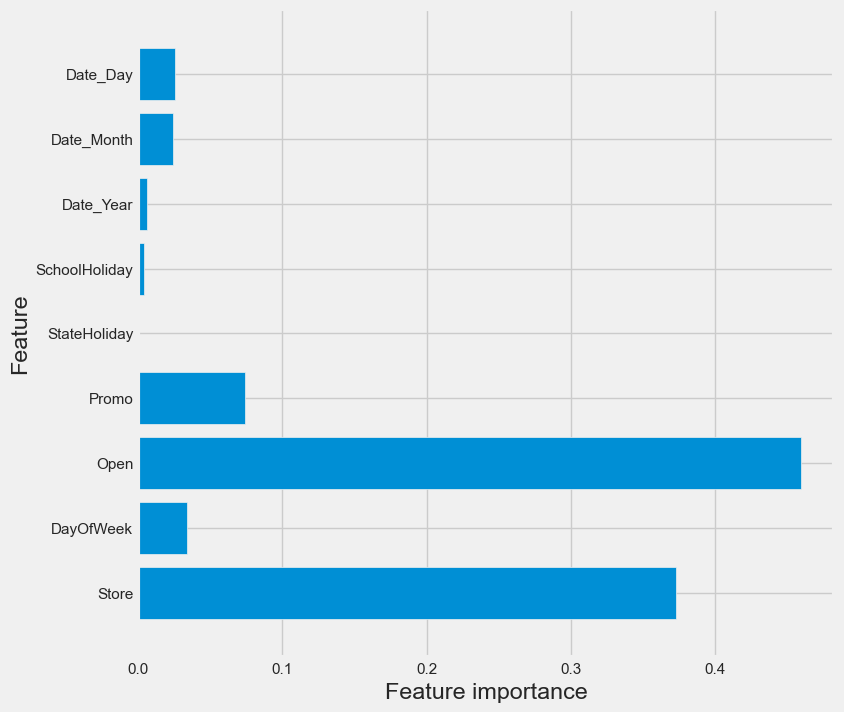

In [68]:
rf = RandomForestRegressor(n_estimators=5, random_state=42)
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)

plot_feature_importance(rf)

Unterschied zu Nico:
```
rf = RandomForestRegressor(n_estimators=5, random_state=42)
rf.fit(x_train, y_train)
print(rf.score(x_test, y_test))

>>> 0.9567322397761868

### 3.4 Decision Tree

Training set score: 1.00
Test set score: 0.76
Average Error: 980.4904 degrees
RMSE = 1883.05


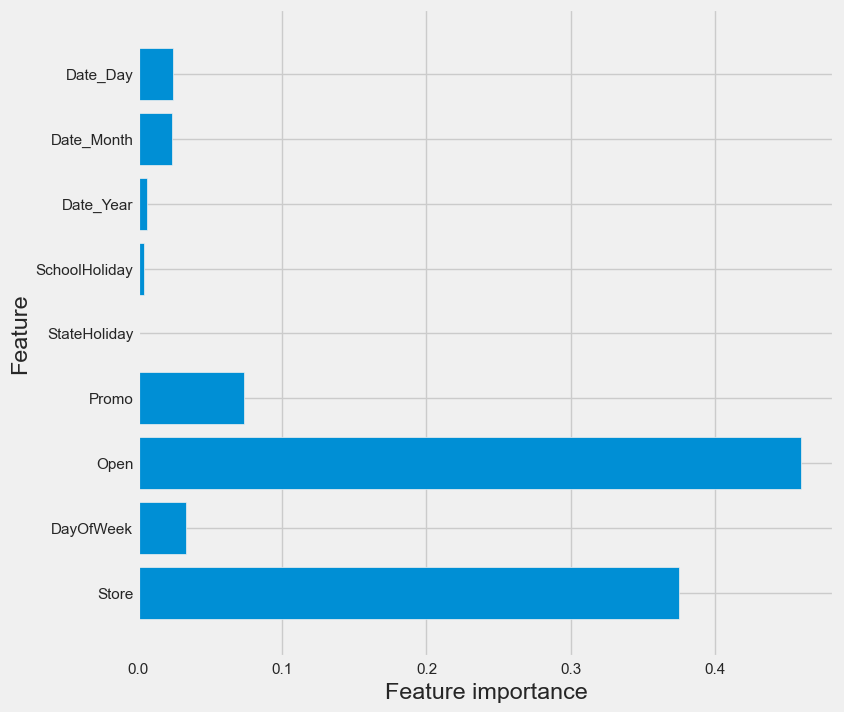

In [69]:
dt = DecisionTreeRegressor(random_state=42)
dt = train_evaluate(dt, X_train, y_train, X_test, y_test)

plot_feature_importance(dt)

Die Performance dieses Decision Tree bei den Trainingsdaten gleicht einem Overfitting (1.00).

Unterschied zu Nico:
```
dt = DecisionTreeRegressor(min_samples_leaf=23, max_depth=27, random_state=42)
dt.fit(x_train, y_train)
print(dt.score(x_test, y_test))

>>> 0.9357382619347128

### 3.5 AdaBoost

Training set score: -1.01
Test set score: -1.01
Average Error: 4536.4523 degrees
RMSE = 5454.02


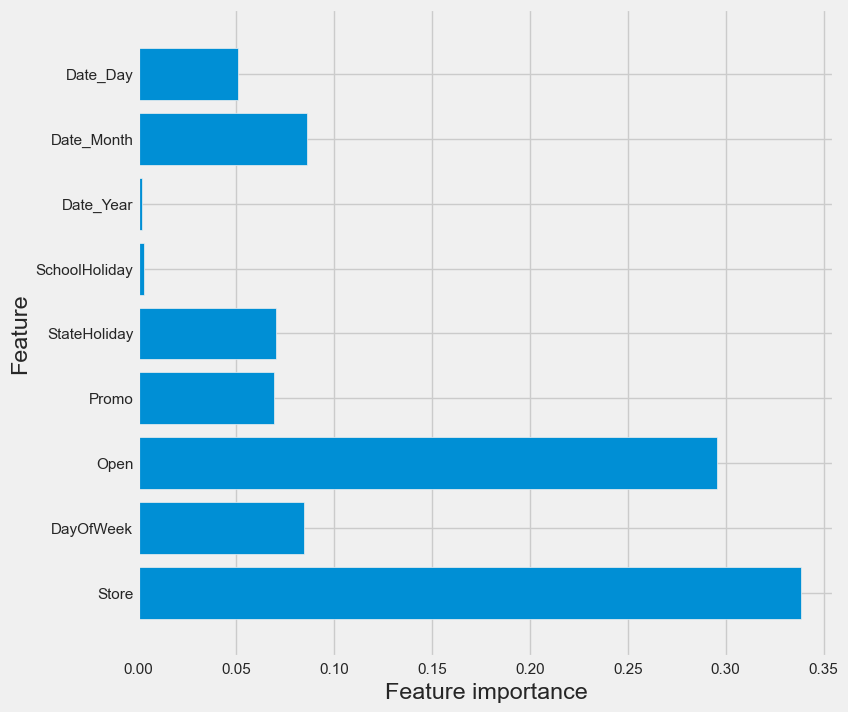

In [70]:
ada = AdaBoostRegressor(random_state=42)
ada = train_evaluate(ada, X_train, y_train, X_test, y_test)

plot_feature_importance(ada)

Unterscheid zu Nico:
```
ada = AdaBoostRegressor(n_estimators=5, random_state=42)
ada.fit(x_train, y_train)
print(ada.score(x_test, y_test))

>>> 0.8411974934216221

### 3.6 Support Vector Machine

In [71]:
svr = SVR(verbose=True, max_iter=1000, tol=0.1, C=1.0, epsilon=0.2)
svr = train_evaluate(svr, X_train, y_train, X_test, y_test)

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -20125866.993050, rho = -11716.990376
nSV = 2000, nBSV = 2000


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training set score: -2.38
Test set score: -2.39
Average Error: 6296.8523 degrees
RMSE = 7081.73


Unterschied zu Nico:
```
pipeline_svr = make_pipeline(SVR())
print(pipeline_svr.get_params())
hyperparameters_svr = {'svr__kernel' : ['rbf'],
                        'svr__C': [0.01, 1, 10],
                        'svr__gamma': [0.01, 1, 10]}
svr_cv = GridSearchCV(pipeline_svr, hyperparameters_svr, cv=10)
svr_cv.fit(x_train, y_train)
print(svr_cv.best_params_)
print(svr_cv.best_score_)
print(svr_cv.score(x_test, y_test))

>>> Kernel ist gestorben.

Liam:

>Mit skalierten Daten crasht mir der Kernel, weshalb auf eine Skalierung verzichtet wird.

### 3.7 Gradient Boost

Training set score: 0.63
Test set score: 0.63
Average Error: 1592.3597 degrees
RMSE = 2338.12


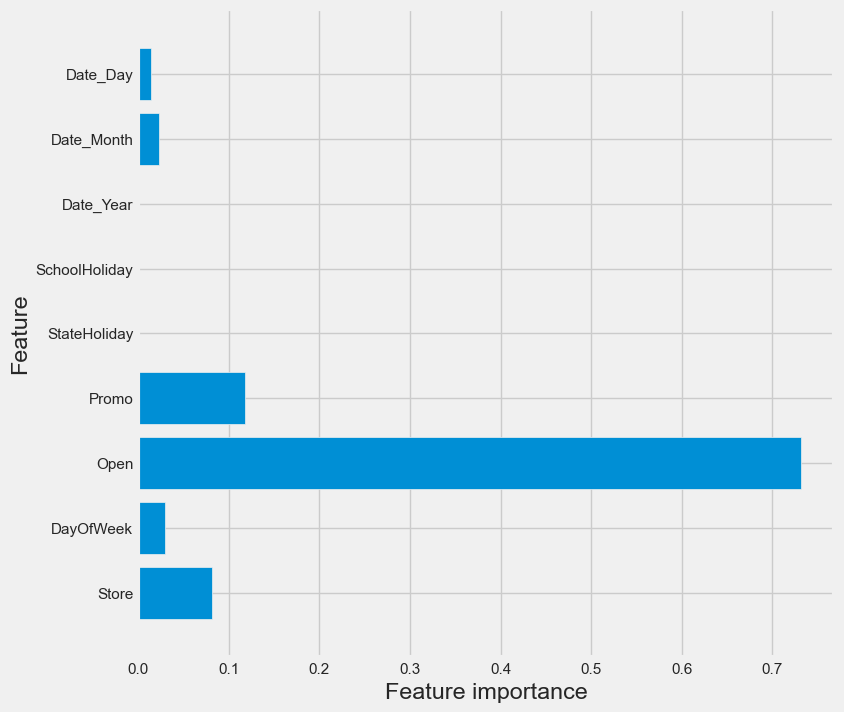

In [72]:
gb = GradientBoostingRegressor(random_state=42)
gb = train_evaluate(gb, X_train, y_train, X_test, y_test)

plot_feature_importance(gb)

Unterschied zu Nico:
```
gbr = GradientBoostingRegressor(n_estimators=5, max_depth=5, random_state=42)
gbr.fit(x_train, y_train)
print(gbr.score(x_test, y_test))

>>> 0.5620337522904908

### 3.8 XGBoost

Training set score: 0.86
Test set score: 0.86
Average Error: 999.5601 degrees
RMSE = 1438.61


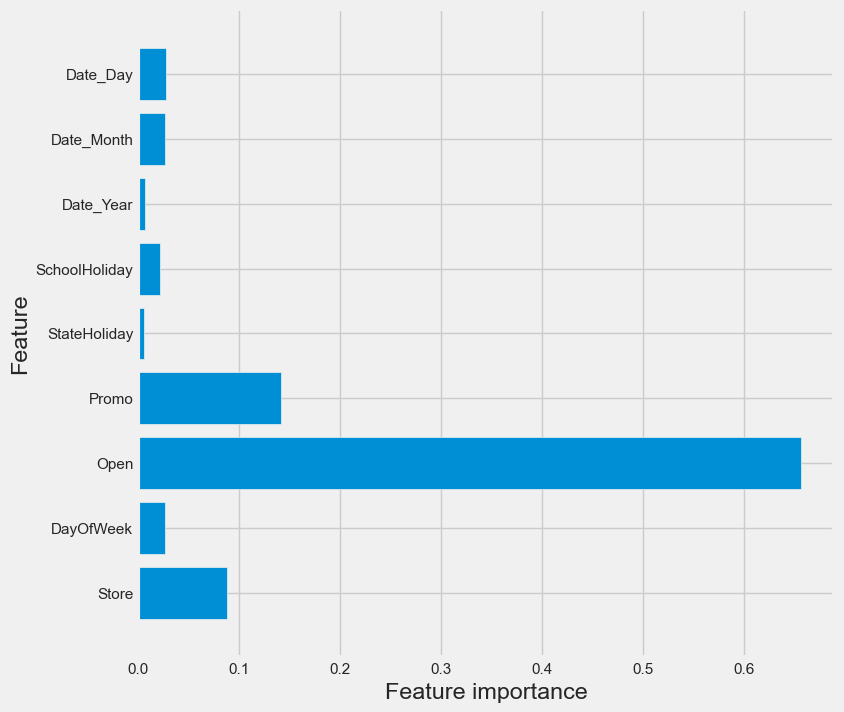

In [73]:
xgb = xgboost.XGBRegressor(random_state=42)
xgb = train_evaluate(xgb, X_train, y_train, X_test, y_test)

plot_feature_importance(xgb)

## 4. Hyperparameter Tuning

Zuvor wurden erste Einblicke in die Feature Importance vorgenommen. Bei den Sales der Rossmann stores spielt "Open" selbstverständlich eine Schlüsselrolle. Wäre der einzelne Store geschlossen, gäbe es auch keinen Umsatz. Durchschnittlich spielt "Promo" eine - wenn auch geringe - Rolle. "StateHoliday" und "SchoolHoliday" üben hingegen keinen Einfluss auf den Umsatz aus. Bei AdaBoost und dem Decision Tree Model hat der Store Type einen vergleichsweise hohen Stellenwert. Um die Feature Importance abschließend zu bewerten, werden im nächsten Schritt die Hyperparameter einzelner Modelle optimiert:

Bevor dies geschieht, wurde die Performance der Modelle mit Standardwerten gemessen. Die Ergebnisse sind in der folgenden Tabelle zusammengefasst.
Die performantesten Modelle werden mit GridSearchCV optimiert, erkennbar an dem ☑ in der Spalte "Hyperparameter Tuning?".

| Model      | Performance | Hyperparameter Tuning?     |
| ---:        |    :----   |          :---: |
| k=5-Nearest Neighbors      | Training set score: 0.73<br>Test set score: 0.46<br>Average Error: 0.4856 degrees<br>RMSE = 0.73| ☑ |
| Logistic Regression   |Training set score: 0.54<br>Test set score: 0.54<br>Average Error: 1770.6203 degrees<br>RMSE = 2614.55|ist im Mittelfeld, daher (vorerst nicht)|
| Random Forest   |Training set score: 0.96<br>Test set score: 0.81<br>Average Error: 918.4684 degrees<br>RMSE = 1664.91| ☑ |
| Decision Tree   |Training set score: 1.00<br>Test set score: 0.76<br>Average Error: 980.4904 degrees<br>RMSE = 1883.05| ☑ |
| AdaBoost   |Training set score: -1.01<br>Test set score: -1.01<br>Average Error: 4536.4523 degrees<br>RMSE = 5454.02|bildet das Schlusslicht|
| Support Vector Machine   |Training set score: -2.38<br>Test set score: -2.39<br>Average Error: 6296.8523 degrees<br>RMSE = 7081.73|bildet das Schlusslicht|
| Gradient Boost   |Training set score: 0.63<br>Test set score: 0.63<br>Average Error: 1592.3597 degrees<br>RMSE = 2338.12|ist im Mittelfeld, daher (vorerst nicht)|
| XGBoost   |Training set score: 0.86<br>Test set score: 0.86<br>Average Error: 999.5601 degrees<br>RMSE = 1438.61| ☑ |

Nach der Optimierung soll die Performance der einzelnen Modelle mit den Testdaten gemessen werden. Außerdem wird die Feature Importance der einzelnen Modelle nochmals betrachtet - sofern möglich. Die Darstellung der "Actual VS Predicted Sales" erfolgte zunächst mit dem Seaborn Scatterplot, später wird das regplot getestet.

In [74]:
# define a function to plot predicted vs actual values
def plot_predicted_vs_actual(model, X, y):
    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(model, X, y, cv=10)

    sns.set_theme(style="whitegrid")
    plt.style.use('fivethirtyeight')

    plt.figure(figsize=(12,12))
    sns.regplot(x=y, y=predicted, truncate=True, scatter_kws={'alpha': 0.1, 's':2}, line_kws={'alpha': 0.5, 'label':'Regression Line', 'color':'#272727'}, label='Predicted Sales')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], lw=2, label='Perfect Prediction', color='#ab2425', alpha=.5)
    plt.xlabel('Actual [$]')
    plt.ylabel('Predicted [$]')
    plt.legend()

    title = '{}: Actual vs Predicted Sales'.format(type(model).__name__)
    sig1 = '__________________________________________________________________________________________________________'
    
    sig2 = '   © NICO BORKOWSKI & LIAM WANDER                                                                                                             Source: Rossmann   '
    plt.title(title, fontsize=26, weight='bold', alpha=.75)
    plt.gcf().text(0.02, 0.02, sig1, fontsize=14, color = 'grey', alpha = .7)
    plt.gcf().text(0.01, 0, sig2, fontsize=14, color = 'grey', alpha = .7)

    plt.show()

### 4.1 Tuning k-Nearest Neighbors

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'n_neighbors': 4}


100%|██████████| 14/14 [04:04<00:00, 17.45s/it]


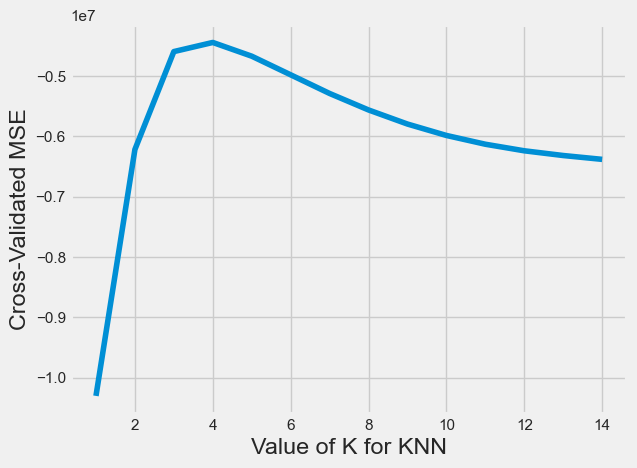

In [75]:
knn = KNeighborsRegressor()

param_grid = {'n_neighbors': np.arange(1, 15)}

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose=1)
knn_gscv.fit(X_train, y_train)

pprint(knn_gscv.best_params_)

k_range = range(1, 15)
k_scores = []
for k in tqdm(k_range):
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

Best K=2 Neighbors. Alles 'drunter und drüber ist weitaus weniger performant. (EDIT 30. März; Nach dem belassen der Daten beim Original ist der beste Wert für K=4)

Training set score: 0.82
Test set score: 0.71
Average Error: 1447.5529 degrees
RMSE = 2086.13


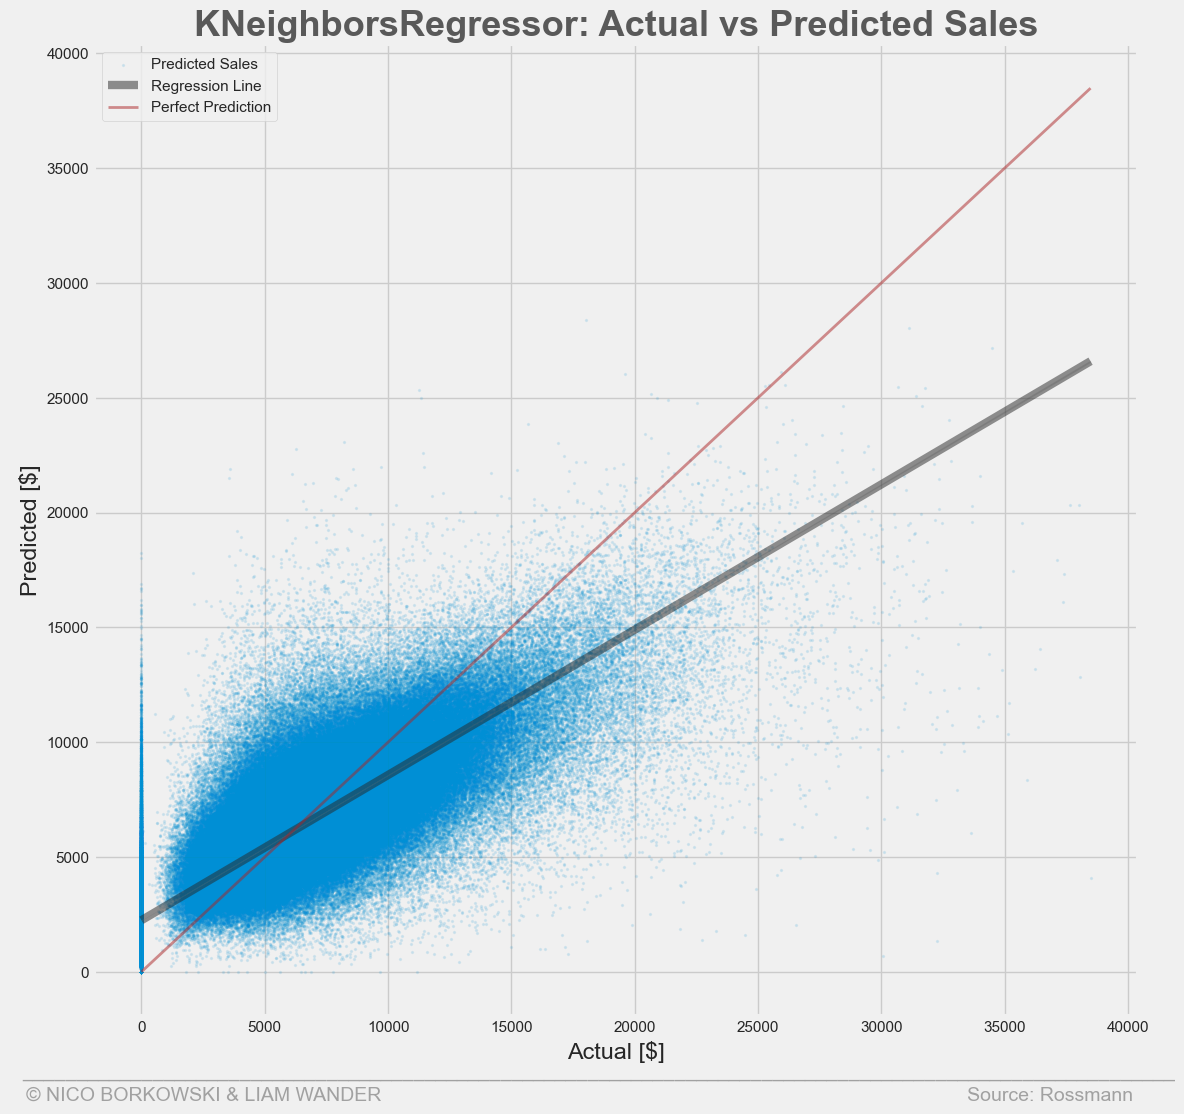

In [76]:
knn = KNeighborsRegressor(n_neighbors=4)
knn = train_evaluate(knn, X_train, y_train, X_test, y_test)

plot_predicted_vs_actual(knn, X_train, y_train)

### 4.2 Tuning the Random Forest

In [77]:
rf = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators': [50, 100, 200],
              'max_features': ['sqrt', 'log2', 'None'],
              'max_depth': [9, 12, 15],
              'max_leaf_nodes': [9, 12, 15]}

rf_gscv = GridSearchCV(rf, param_grid, cv=5, verbose=2)
rf_gscv.fit(X_train, y_train)

pprint(rf_gscv.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=50; total time=   7.0s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=50; total time=   6.9s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=50; total time=   6.9s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=50; total time=   6.8s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=50; total time=   6.8s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=100; total time=  13.5s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=100; total time=  13.5s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=100; total time=  13.7s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=100; total time=  13.5s
[CV] END max_depth=9, max_features=sqrt, max_leaf_nodes=9, n_estimators=100; to

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 341, in fit
    self._validate_params()
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.10/site-pack

{'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': 15,
 'n_estimators': 50}


Training set score: 0.57
Test set score: 0.57
Average Error: 1677.4347 degrees
RMSE = 2524.19


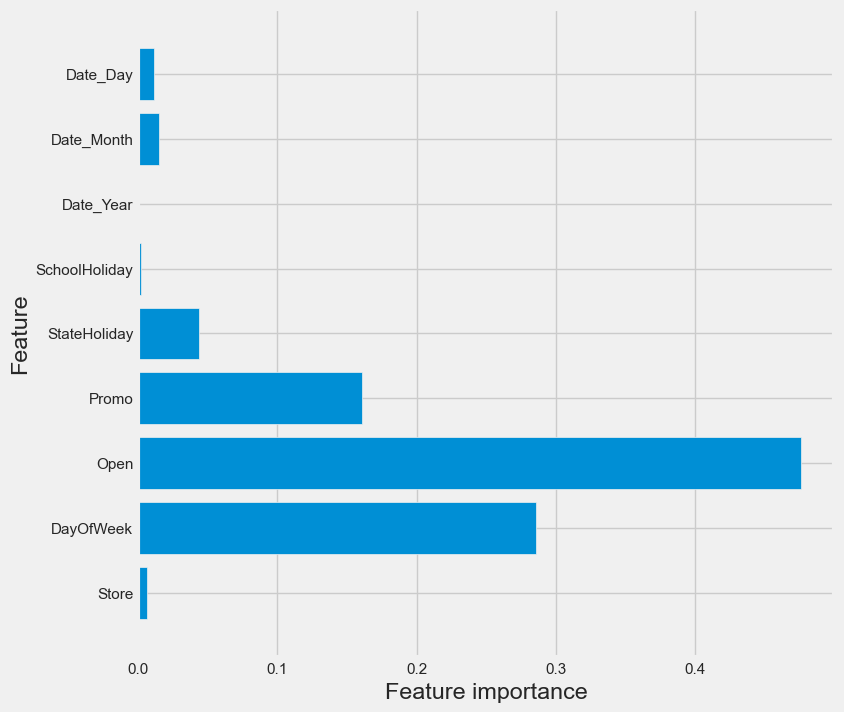

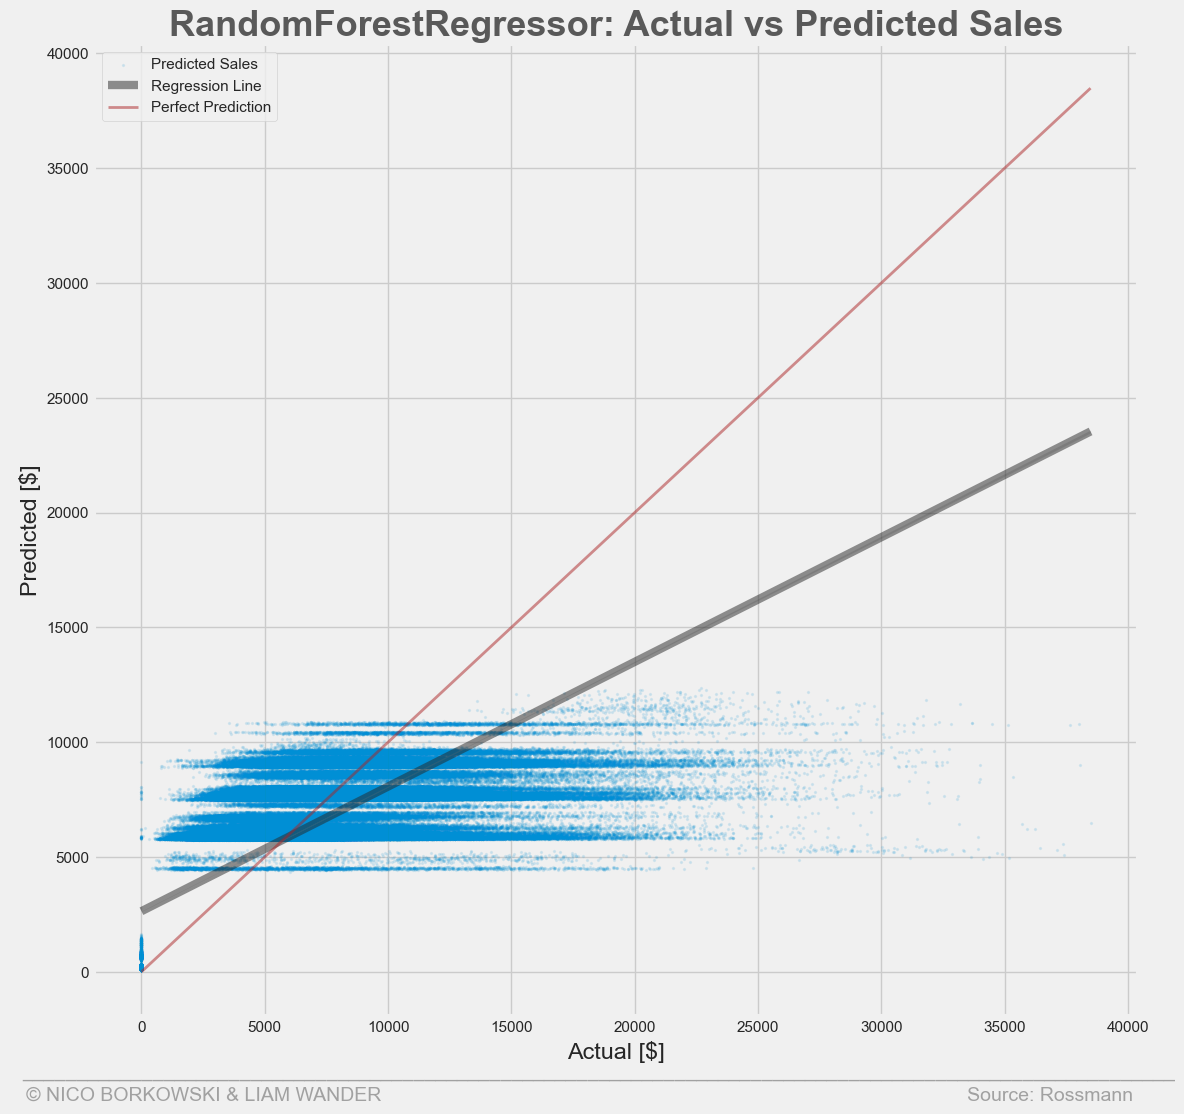

In [79]:
rf = RandomForestRegressor(n_estimators=50, max_features='sqrt', max_depth=12, max_leaf_nodes=15, random_state=42)
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)

plot_feature_importance(rf)
plot_predicted_vs_actual(rf, X_train, y_train)

Nach der Optimierung der Hyperparameter ist die Performance des Random Forests deutlich gesunken, der Root Mean Squared Error liegt bei 2555.33$“. Auch die Feature Importance lässt zu Wünschen übrig: Der Umsatz ist nach wie vor von der Öffnung und dem Wochentag abhängig.

In [80]:
rf = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
              'max_features': ['sqrt', 'log2', 'None'],
              'max_depth': [9, 12, 15, 18, 21, 24],
              'max_leaf_nodes': [9, 12, 15, 18, 21, 24]}

random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, verbose=2)

random_search.fit(X_train, y_train)
pprint(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=24, max_features=log2, max_leaf_nodes=12, n_estimators=400; total time=  58.4s
[CV] END max_depth=24, max_features=log2, max_leaf_nodes=12, n_estimators=400; total time= 1.0min
[CV] END max_depth=24, max_features=log2, max_leaf_nodes=12, n_estimators=400; total time= 1.0min
[CV] END max_depth=24, max_features=log2, max_leaf_nodes=12, n_estimators=400; total time=  59.1s
[CV] END max_depth=24, max_features=log2, max_leaf_nodes=12, n_estimators=400; total time=  59.5s
[CV] END max_depth=9, max_features=None, max_leaf_nodes=18, n_estimators=50; total time=   0.0s
[CV] END max_depth=9, max_features=None, max_leaf_nodes=18, n_estimators=50; total time=   0.0s
[CV] END max_depth=9, max_features=None, max_leaf_nodes=18, n_estimators=50; total time=   0.0s
[CV] END max_depth=9, max_features=None, max_leaf_nodes=18, n_estimators=50; total time=   0.0s
[CV] END max_depth=9, max_features=None, max_leaf_nodes=18, n_est

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 341, in fit
    self._validate_params()
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.10/site-package

{'max_depth': 21,
 'max_features': 'sqrt',
 'max_leaf_nodes': 24,
 'n_estimators': 100}


Training set score: 0.58
Test set score: 0.58
Average Error: 1660.9261 degrees
RMSE = 2502.93


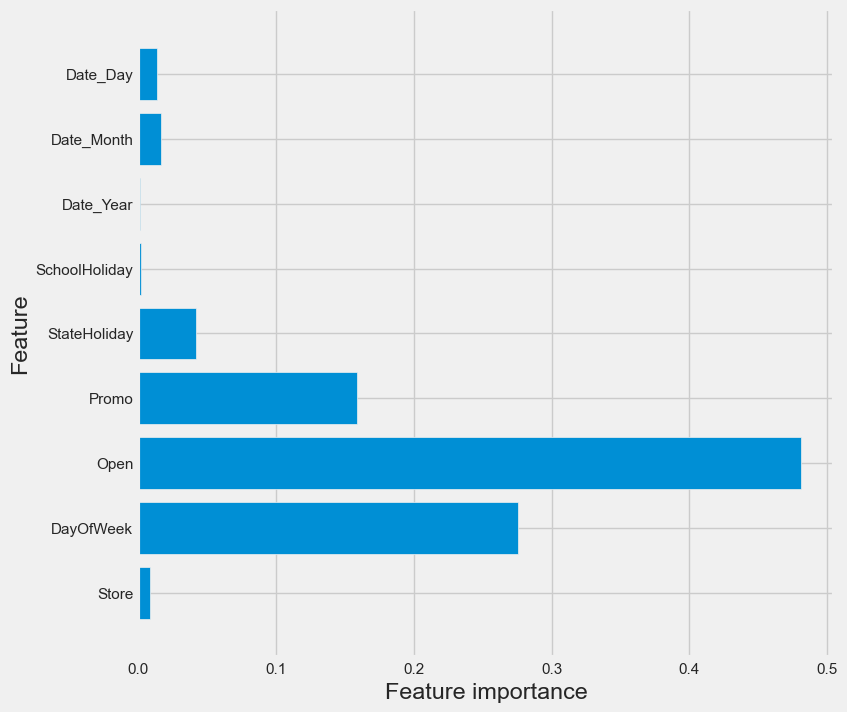

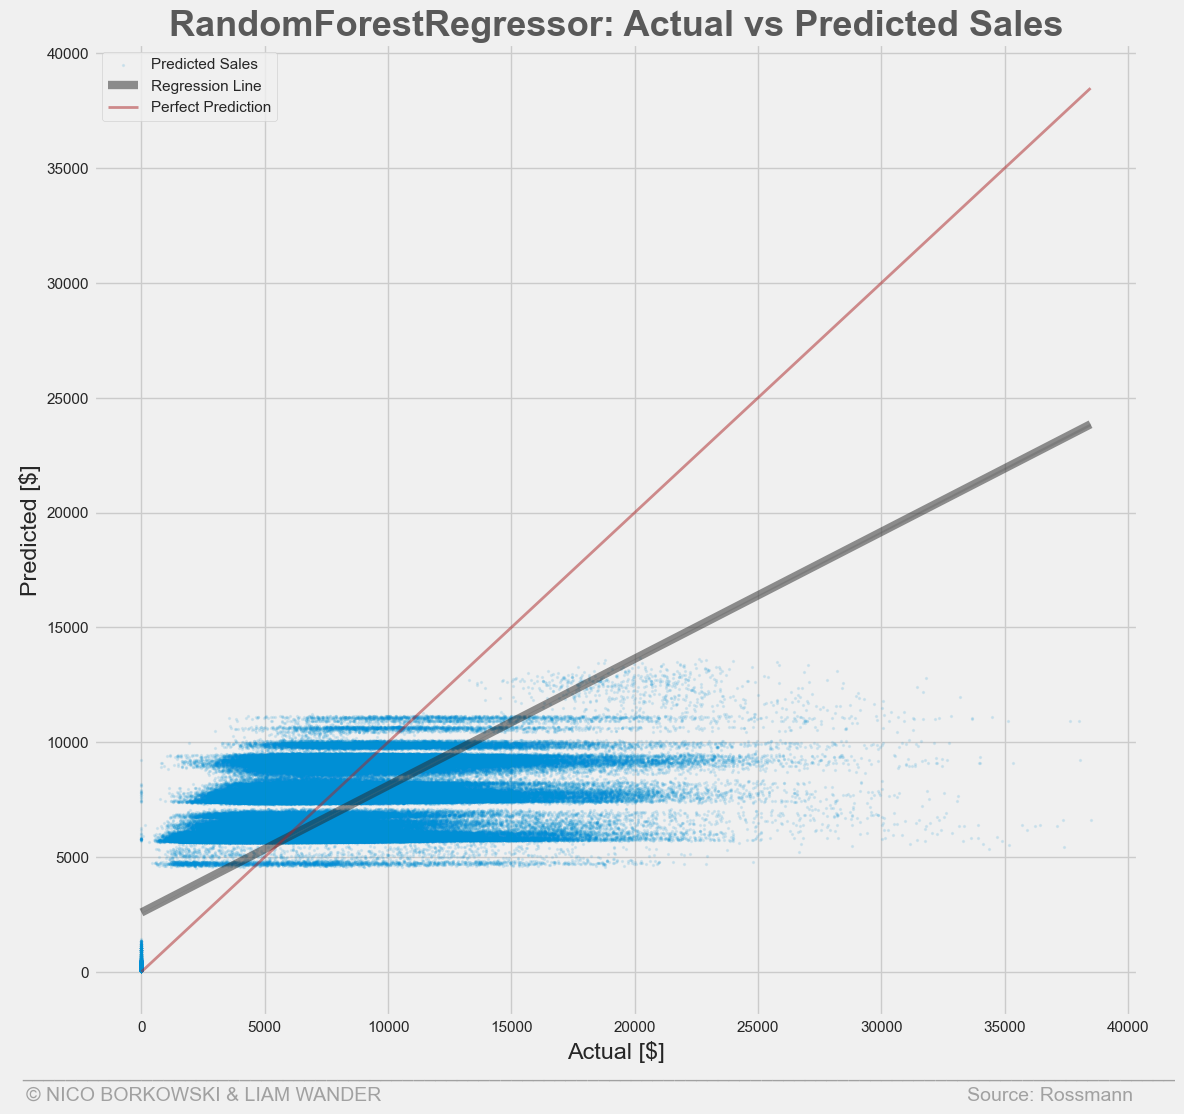

In [82]:
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=21, max_leaf_nodes=24, random_state=42)
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)
plot_feature_importance(rf)
plot_predicted_vs_actual(rf, X_train, y_train)

Training set score: 0.98
Test set score: 0.84
Average Error: 841.5616 degrees
RMSE = 1519.53


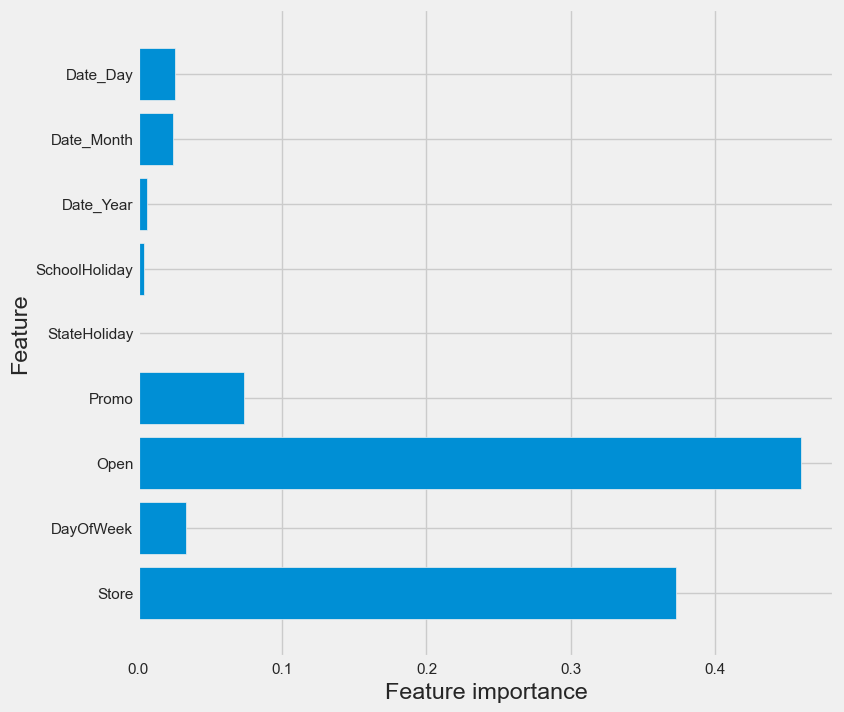

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


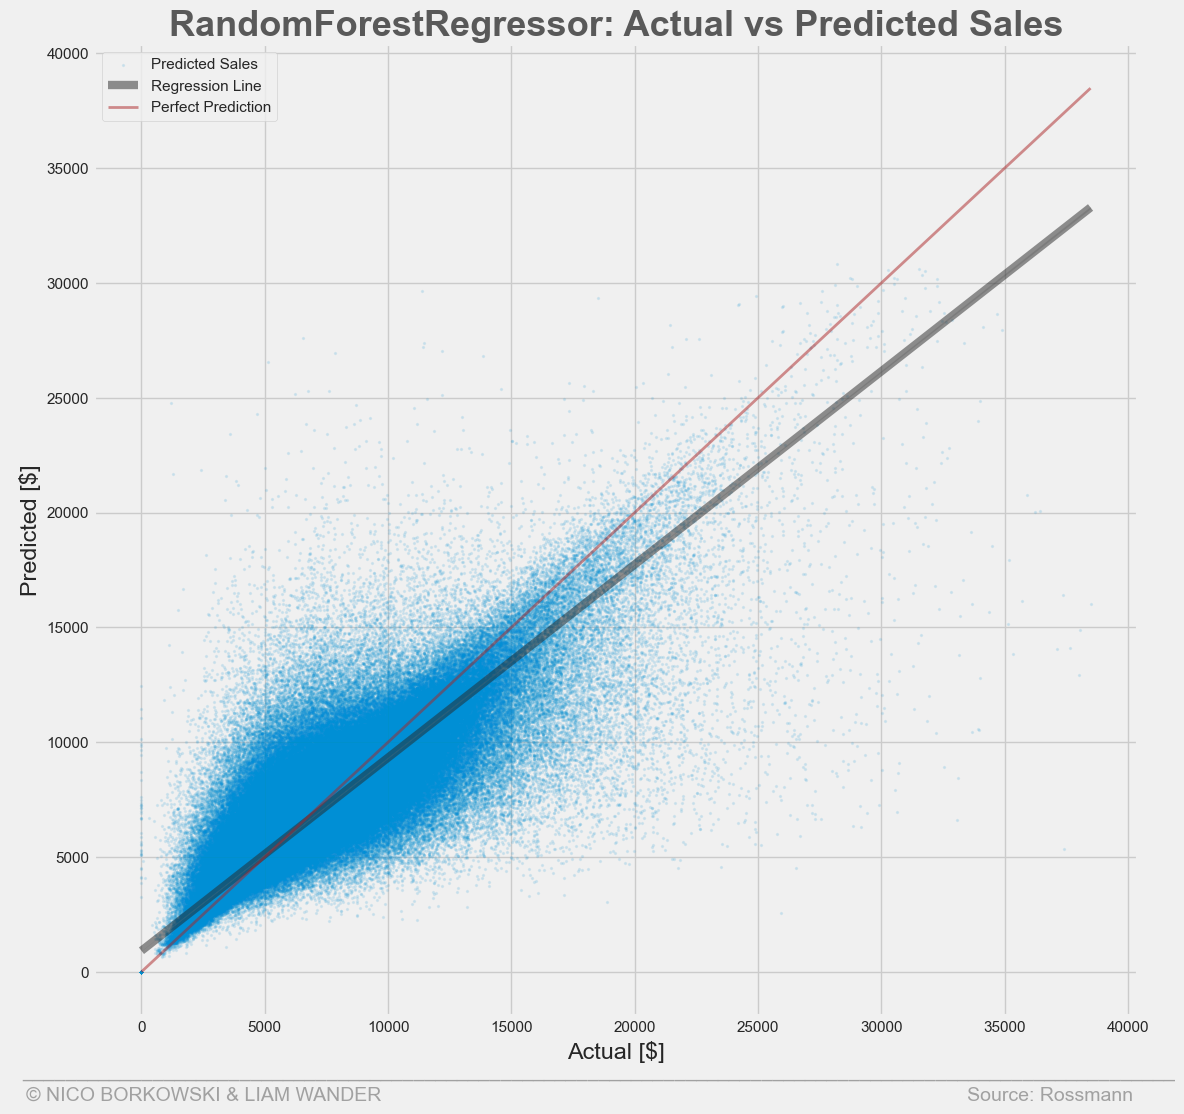

In [84]:
# print standard parameters of a random forest
rf = RandomForestRegressor(random_state=42)
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)

plot_feature_importance(rf)
pprint(rf.get_params())
plot_predicted_vs_actual(rf, X_train, y_train)

-> Mit den Standardwerten des Random Forests werden mit Abstand die besten Werte erzielt, wobei das ganze eventuell an overfitting grenzt. Aufgrundlage der Feature Importance (Store vs Wochentag) wird letztendlich mit dem getunten random Forest, das Stacking Ensemble gefüttert. Wahrscheinlich bildet das die Realität mehr nach als die Standardwerte.

### 4.3 Tuning the Decision Tree

Training set score: 1.00
Test set score: 0.76
Average Error: 980.4904 degrees
RMSE = 1883.05


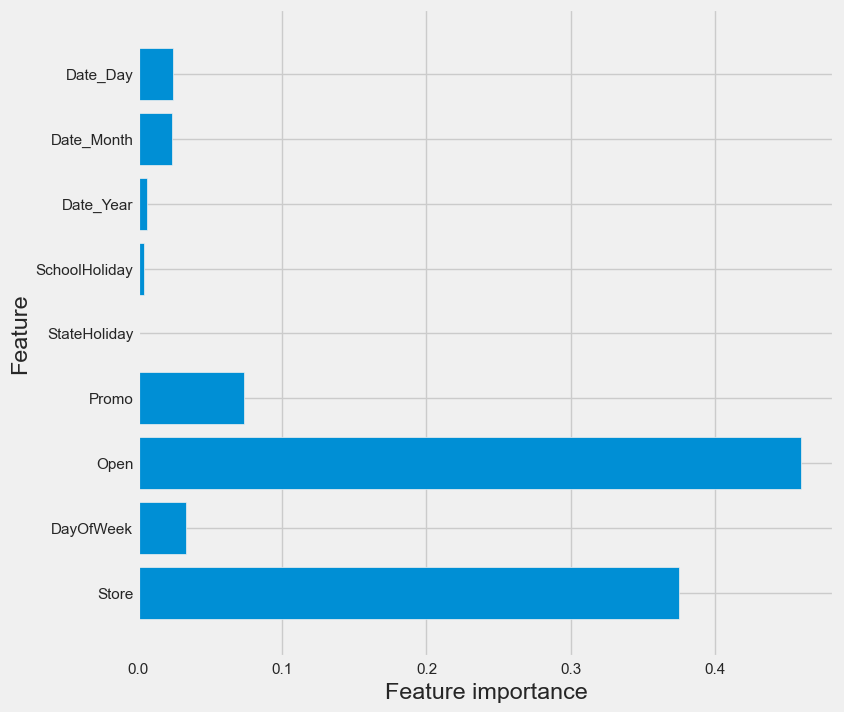

In [85]:
dt = DecisionTreeRegressor(random_state=42)
dt = train_evaluate(dt, X_train, y_train, X_test, y_test)
plot_feature_importance(dt)

In [86]:
dt = DecisionTreeRegressor(random_state=42)

parameters = {'criterion': ['poisson', 'friedman_mse', 'squared_error'], 
              'max_depth': [2,4,6,8,10], 
              'max_features': [1,3,5,7,10,15,20],                
              'min_samples_split': [2,3,4,5,6,7]}

dt_gscv = GridSearchCV(dt, parameters, cv=5, verbose=2)
dt_gscv.fit(X_train, y_train)

pprint(dt_gscv.best_params_)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=3; total time=   0.0s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=3; total time=   0.0s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=3; total time=   0.0s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_samples_split=3; total time=   0.0s
[CV] END criterion=poisson, max_depth=2, max_features=1, min_sa

Training set score: 0.60
Test set score: 0.60
Average Error: 1599.8177 degrees
RMSE = 2428.04


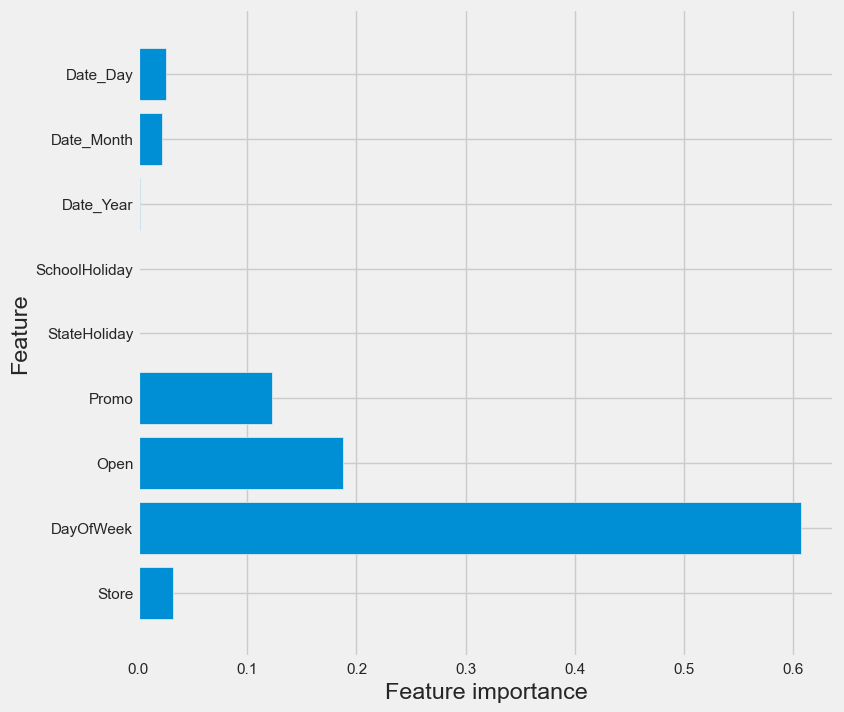

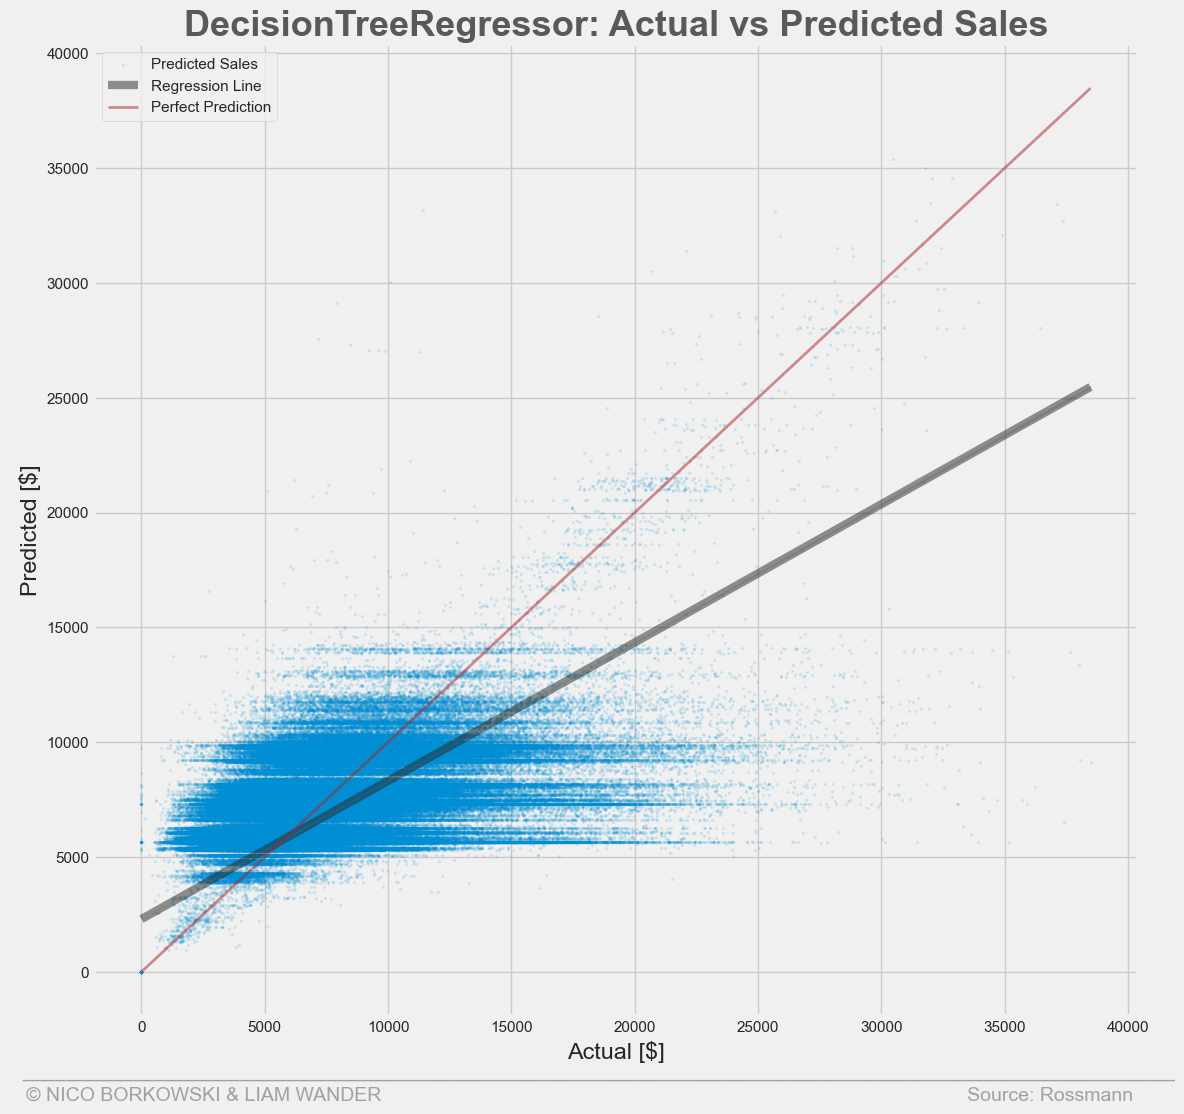

In [90]:
dt = DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, max_features=7, min_samples_split=7, random_state=42)
dt = train_evaluate(dt, X_train, y_train, X_test, y_test)
plot_feature_importance(dt)
plot_predicted_vs_actual(dt, X_train, y_train)

### 4.4 Tuning XGBoost

Training set score: 0.86
Test set score: 0.86
Average Error: 999.5601 degrees
RMSE = 1438.61


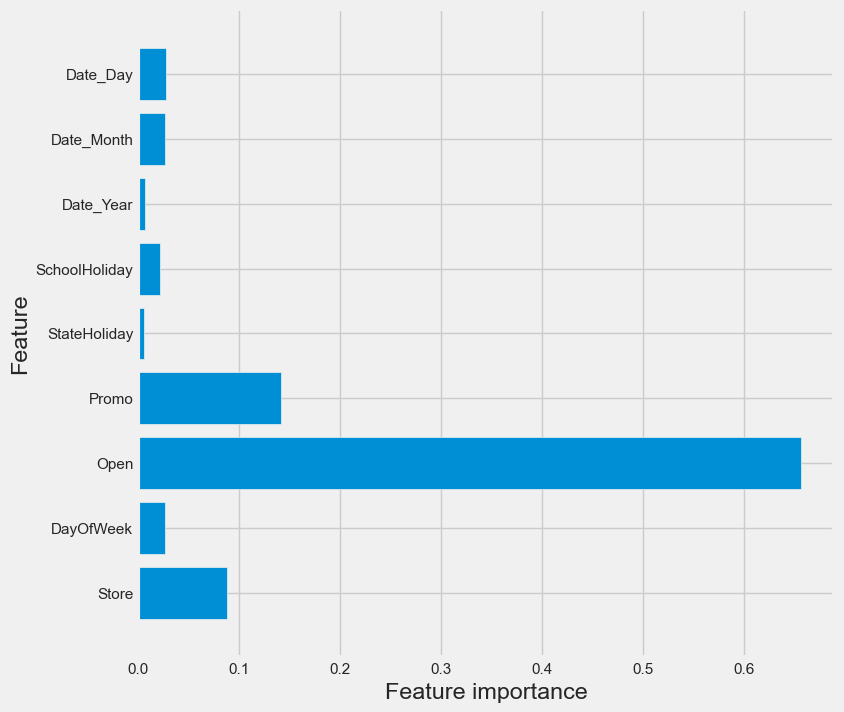

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=0.75; total time=   4.1s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=0.75; total time=   4.1s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=0.75; total time=   4.0s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=0.75; total time=   3.9s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=0.75; total time=   4.0s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=1; total time=   3.0s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=1; total time=   3.0s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=2, min_child_weight=1, subsample=1; total time=   

In [88]:
xgb = xgboost.XGBRegressor(random_state=42)

xgb = train_evaluate(xgb, X_train, y_train, X_test, y_test)

plot_feature_importance(xgb)

PARAMETERS = {"subsample":[0.75, 1],
              "colsample_bytree":[0.75, 1],
              "max_depth":[2, 6],
              "min_child_weight":[1, 5],
              "learning_rate":[0.1, 0.01]}

xgb_gscv = GridSearchCV(xgb, PARAMETERS, cv=5, verbose=2)
xgb_gscv.fit(X_train, y_train)
pprint(xgb_gscv.best_params_)

Training set score: 0.73
Test set score: 0.73
Average Error: 1376.7007 degrees
RMSE = 2012.41


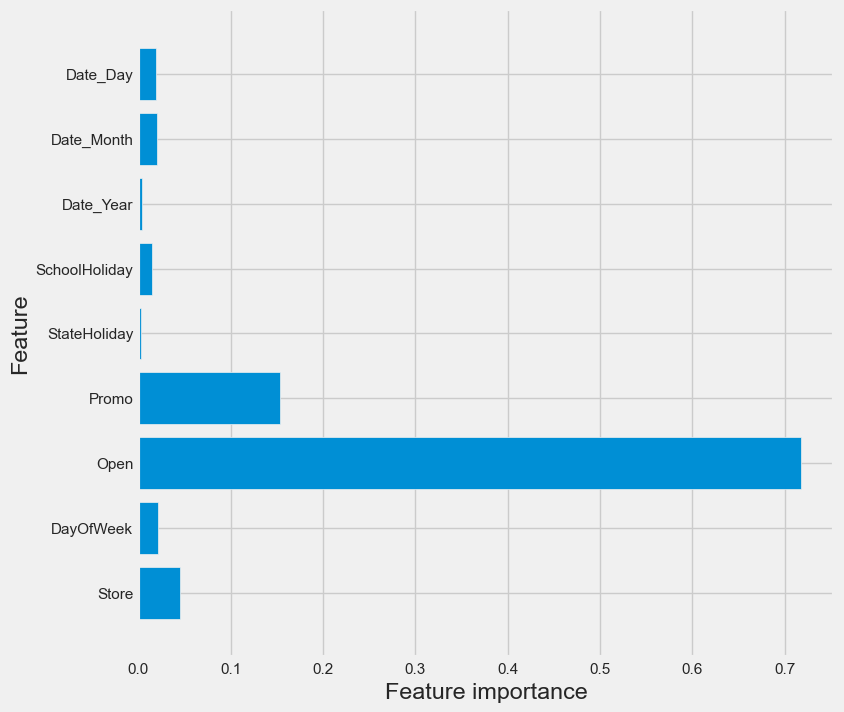

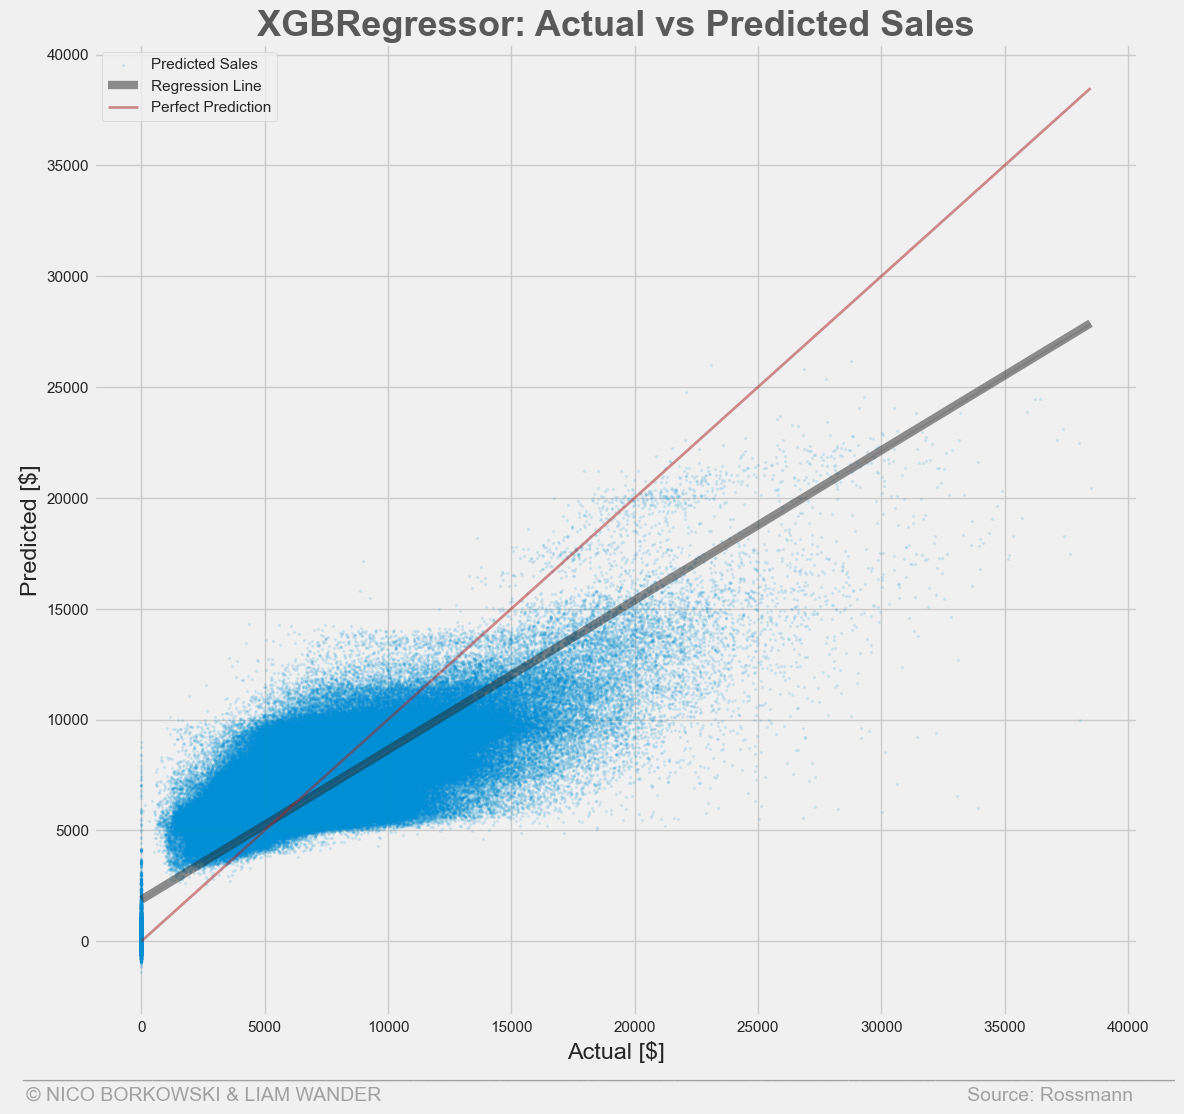

In [89]:
xgb = xgboost.XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=6, min_child_weight=1, subsample=0.75, random_state=42)
xgb = train_evaluate(xgb, X_train, y_train, X_test, y_test)

plot_feature_importance(xgb)
plot_predicted_vs_actual(xgb, X_train, y_train)

## 5. Ensemble Method: Stacking

Während Bagging und Boosting homogene (gleich) schwache Lernmodelle für das Ensemble verwenden, berücksichtigt Stacking oft heterogene (unterschiedlich) schwache Lerner, lernt sie parallel und kombiniert sie durch Training eines Meta-Learners, um eine Vorhersage auf der Grundlage der verschiedenen schwachen Lerner-Vorhersagen auszugeben. Ein Meta-Lerner liest die Vorhersagen als Merkmale ein und das Ziel sind Grundwahrheitswerte. 

Bei einem Mittelwertbildungs-Ensemble (wie dem Random Forest) kombiniert das Modell die Vorhersagen von mehreren trainierten Modellen. Eine Einschränkung dieses Ansatzes besteht darin, dass jedes Modell den gleichen Beitrag zur Ensemble-Vorhersage leistet, unabhängig davon, wie gut das Modell abgeschnitten hat. Ein alternativer Ansatz ist ein gewichtetes Durchschnitts-Ensemble, bei dem der Beitrag der einzelnen Ensemble-Mitglieder nach dem Vertrauen in ihren Beitrag zu den besten Vorhersagen gewichtet wird. Das gewichtete Durchschnittsensemble bietet eine Verbesserung gegenüber dem Modell-Durchschnittsensemble.

Eine weitere Verallgemeinerung dieses Ansatzes besteht darin, die lineare gewichtete Summe durch lineare Regression (Regressionsproblem) oder logistische Regression (Klassifizierungsproblem) zu ersetzen, um die Vorhersagen der Teilmodelle mit einem beliebigen Lernalgorithmus zu kombinieren. Dieser Ansatz wird als Stacking bezeichnet.

> Beim Stacking nimmt ein Algorithmus die Ausgaben der Teilmodelle als Eingabe und versucht zu lernen, wie die Eingabevorhersagen am besten kombiniert werden können, um eine bessere Ausgabevorhersage zu erhalten.

[vgl. Ensemble Stacking for ML & DL](https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/)

In [98]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('knn', KNeighborsRegressor(n_neighbors=4)))
    level0.append(('dt', DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, max_features=7, min_samples_split=7, random_state=42)))
    level0.append(('rf', RandomForestRegressor(random_state=42)))
    level0.append(('xgb', xgboost.XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=6, min_child_weight=1, subsample=0.75, random_state=42)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn'] = KNeighborsRegressor(n_neighbors=4)
    models['dt'] = DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, max_features=7, min_samples_split=7, random_state=42)
    models['rf'] = RandomForestRegressor(random_state=42)
    models['xgb'] = xgboost.XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=6, min_child_weight=1, subsample=0.75, random_state=42)
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores


Mit dem stacking ensemble werden die Ergebnisse der einzelnen Modelle kombiniert. Hierfür wird ein Meta-Modell verwendet, welches die Vorhersagen der einzelnen Modelle als Features verwendet und die Vorhersage des Meta-Modells als Target. Das Meta-Modell lernt dann, wie die einzelnen Vorhersagen kombiniert werden müssen, um eine bessere Vorhersage zu erzielen. Hiermit wird weitergearbeitet.

## 6. Submission

Das ist mit Abstand der schwerste Teil, da ich kein richtiges Verfahren kenne wie ich aus dem test.csv-Datensatz Sales predicten könnte. Ein Stackingmodell bestehend aus KNN, Random Forest, Decision Tree und XGBoost sowie dem Meta-Modell Linear Regression liegt vor. Zunächst habe ich versucht das Modell mit den Inhalten aus train.csv (bis auf Sales) zu trainieren und dann dieses Modell auf einen test.csv Datensatz loszulassen. Doch bereits an der Umsetzung scheitert es, da ich X und y von test.csv nicht sinnvoll voneinander trennen kann (Sales ist eben nicht vorhanden). Meine Idee wäre es Sales aus train.csv mit der StoreID aus test.csv zu mappen um ein X DataFrame zu erhalten, was letztendlich sinnfrei ist.

-------knn-------
Coefficient of determination: 0.7162463225289641
Root Mean Squared Error: 2048.505625852676
>knn -2067.412 (14.105)
Computation Time: 10.356644868850708
----------------------------------

-------dt-------
Coefficient of determination: 0.6013632076185136
Root Mean Squared Error: 2428.035887122603
>dt -1604.212 (13.857)
Computation Time: 2.187535047531128
----------------------------------

-------rf-------
Coefficient of determination: 0.8438697077376422
Root Mean Squared Error: 1519.532516443564
>rf -1137.427 (18.569)
Computation Time: 444.54618096351624
----------------------------------

-------xgb-------
Coefficient of determination: 0.7271720981937316
Root Mean Squared Error: 2008.6802208972344
>xgb -1382.338 (12.970)
Computation Time: 1318.015912771225
----------------------------------

-------stacking-------
Coefficient of determination: 0.8607581954715812
Root Mean Squared Error: 1434.9977929530844
>stacking -1144.502 (15.713)
Computation Time: 2380.635970830

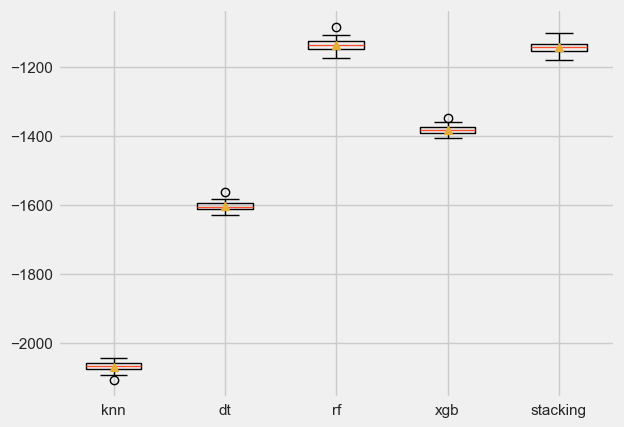

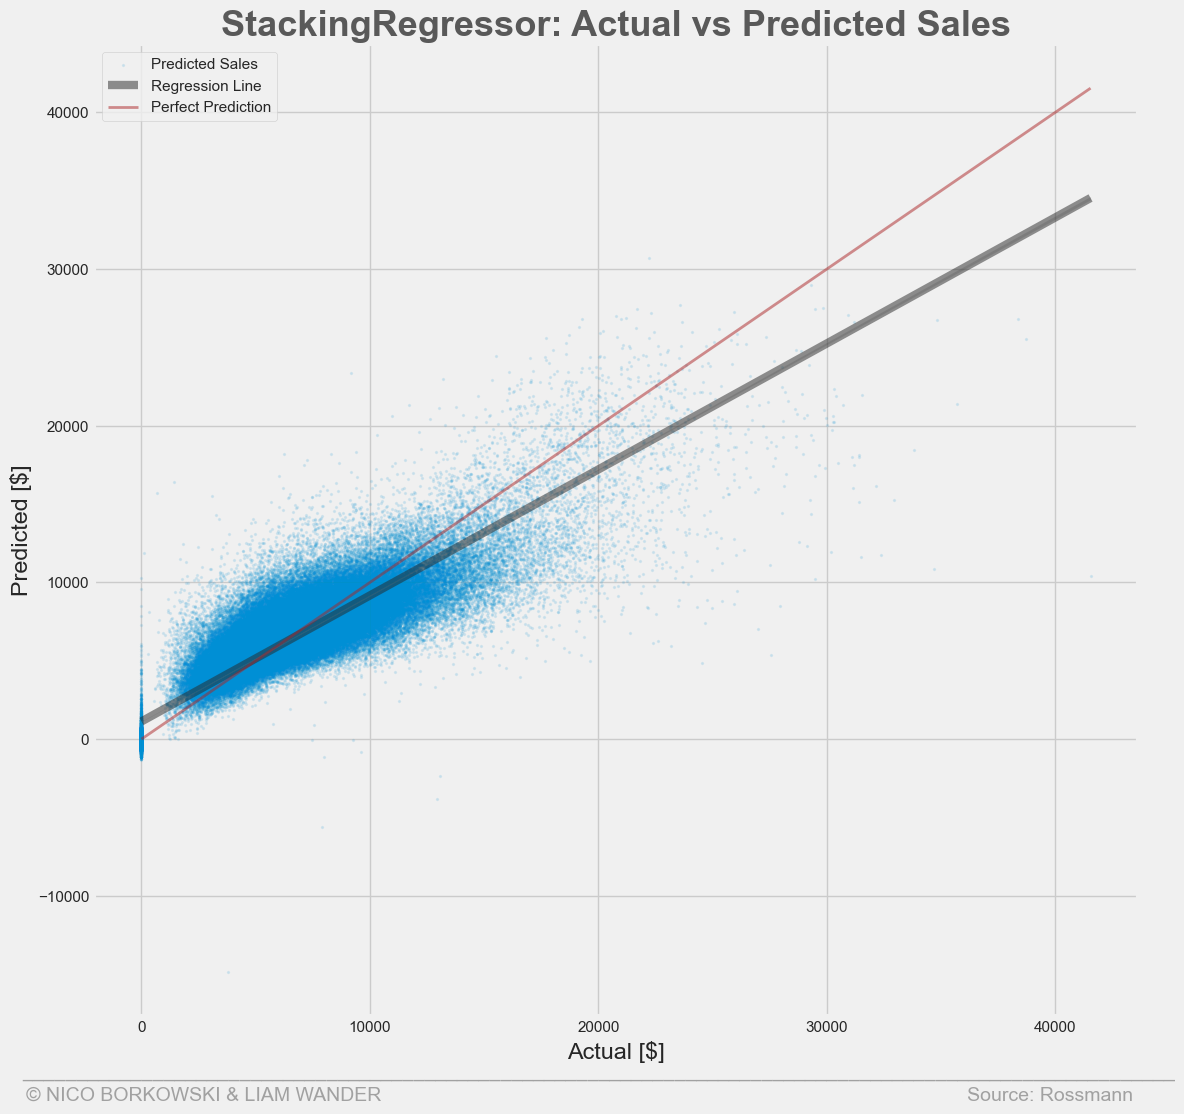

In [122]:
models = get_models()
results, names = list(), list()

for name, model in models.items():
    start_time = time.time()
    scores = evaluate_model(model, X_test, y_test)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, prediction, squared = False)
    end_time = time.time()
    results.append(scores)
    names.append(name)
    print("-------{}-------".format(name))
    print("Coefficient of determination: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")
# plot each models performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

plot_predicted_vs_actual(models['stacking'], X_test, y_test)
test['Sales'] = models['stacking'].predict(test.drop('Id', axis=1))
test['Sales'] = test['Sales'].astype(int)
test = test.drop(['Date_Year', 'Date_Month', 'Date_Day'], axis=1)
test = test[['Id', 'Sales']]
test.to_csv('submission.csv', index=False)




-------knn-------
Coefficient of determination: 0.7162463225289641
Root Mean Squared Error: 2048.505625852676
>knn -2067.412 (14.105)
Computation Time: 11.164736986160278
----------------------------------

-------dt-------
Coefficient of determination: 0.6013632076185136
Root Mean Squared Error: 2428.035887122603
>dt -1604.212 (13.857)
Computation Time: 2.1890459060668945
----------------------------------

-------rf-------
Coefficient of determination: 0.8438697077376422
Root Mean Squared Error: 1519.532516443564
>rf -1137.427 (18.569)
Computation Time: 425.89284682273865
----------------------------------

-------xgb-------
Coefficient of determination: 0.7271720981937316
Root Mean Squared Error: 2008.6802208972344
>xgb -1382.338 (12.970)
Computation Time: 67.77959179878235
----------------------------------

-------stacking-------
Coefficient of determination: 0.8607581954715812
Root Mean Squared Error: 1434.9977929530844
>stacking -1144.502 (15.713)
Computation Time: 2390.59928226

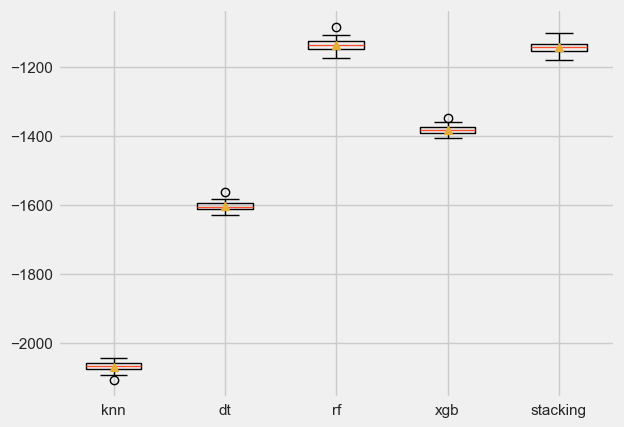

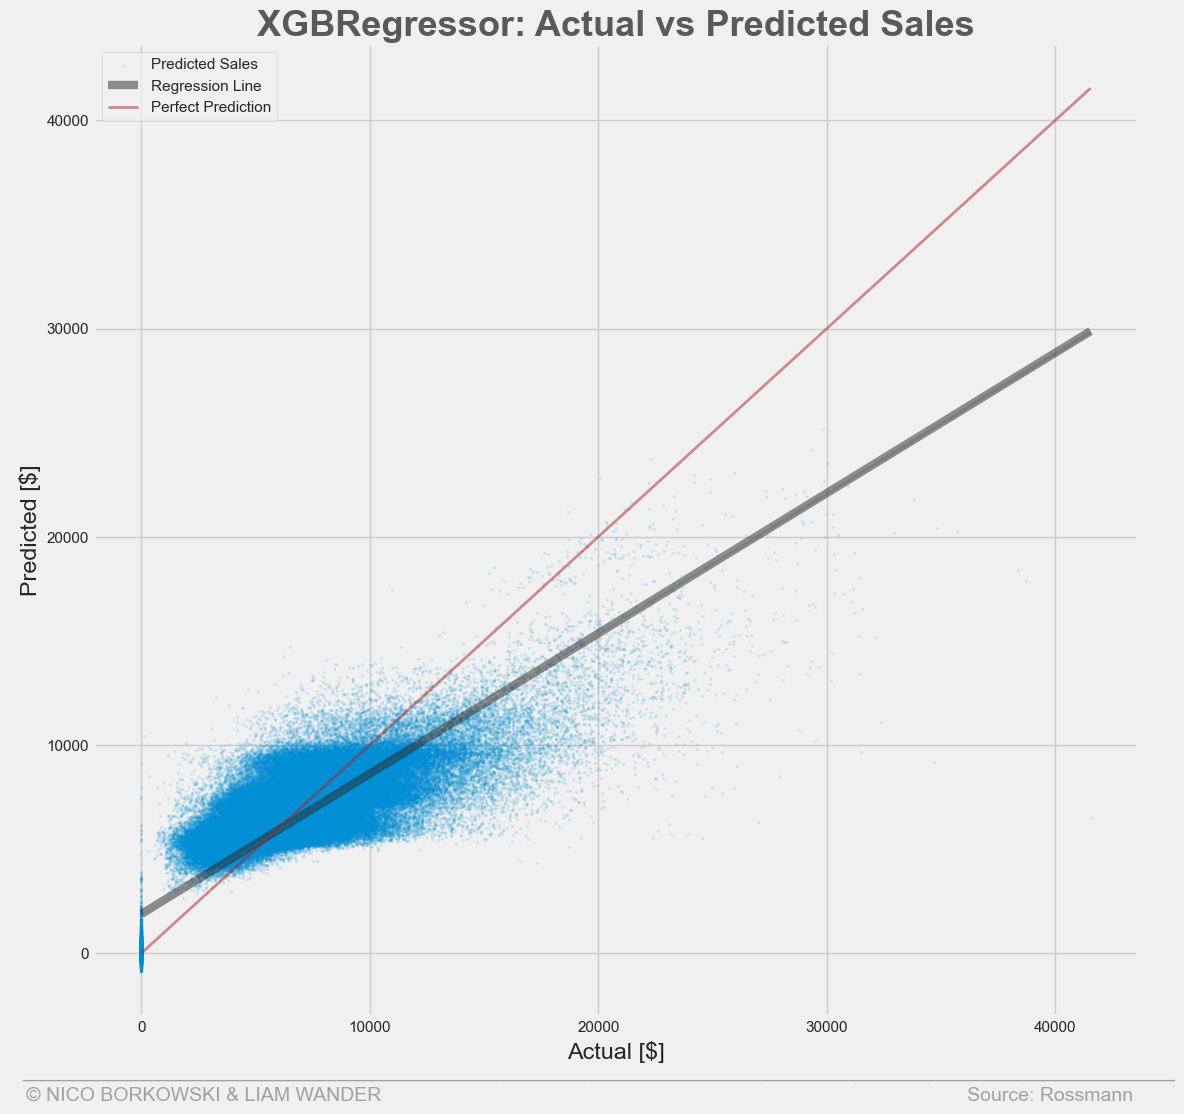

In [147]:
models = get_models()
results, names = list(), list()

for name, model in models.items():
    start_time = time.time()
    scores = evaluate_model(model, X_test, y_test)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, prediction, squared = False)
    end_time = time.time()
    results.append(scores)
    names.append(name)
    print("-------{}-------".format(name))
    print("Coefficient of determination: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")
# plot each models performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

plot_predicted_vs_actual(models['xgb'], X_test, y_test)

test['Sales'] = models['xgb'].predict(test.drop('Id', axis=1))
test['Sales'] = test['Sales'].astype(int)
test = test.drop(['Date_Year', 'Date_Month', 'Date_Day'], axis=1)
test = test[['Id', 'Sales']]
test.to_csv('submission-xgb.csv', index=False)

Submission Datei erstellt, wieder reimportiert - nach Id sortiert und überschrieben. 
Jetzt sollte es passen. Nur habe ich negative Umsätze die mich irritieren.

Allerdings fehlen ein paar Daten bzw. Zeilen in der Submission Datei (41041) VS (41088) im test.csv Datensatz. Ich habe keinen Schimmer woher das kommt.

Nachdem ich unter DataCleaning (2) die Store Daten wieder entfernt habe, ist die Performance des Stacking Modells leider schlechter geworden. XGBoost belegt nun den 1. PLatz. Zuvor waren die mean scores vom stacking bei -888/std: 7,5 (ein paar commits früher), nun stehts bei -1040/std: 11,5

Deswegen nutze ich zum ersten Submit das stacking model - der zweite Versuch wird mit dem XGBoost Modell durchgeführt.

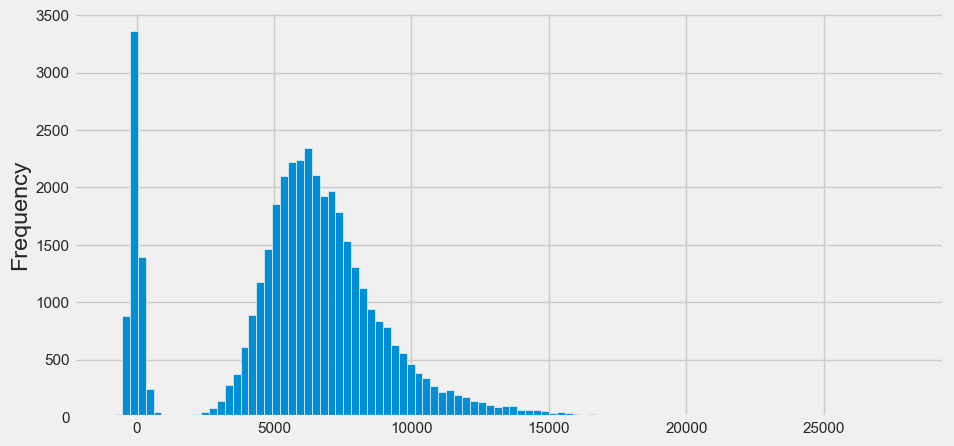

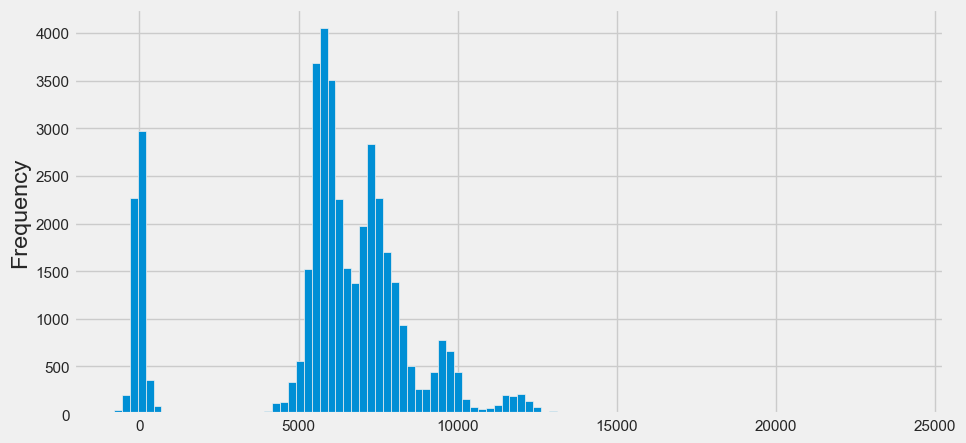

In [148]:
# plot submission file
submission = pd.read_csv('submission.csv')
submission['Sales'].plot(kind='hist', bins=100, figsize=(10, 5))
plt.show()

# plot submission-xgb file
submission_xgb = pd.read_csv('submission-xgb.csv')
submission_xgb['Sales'].plot(kind='hist', bins=100, figsize=(10, 5))
plt.show()

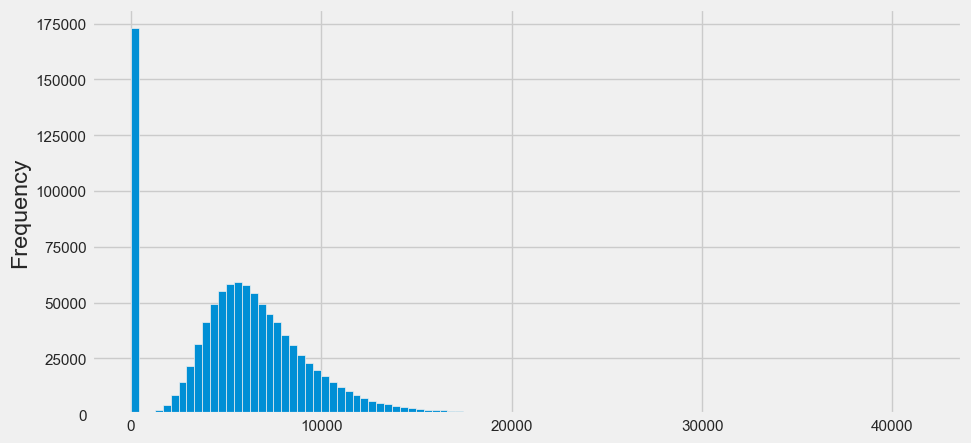

In [149]:
# plot train file
train['Sales'].plot(kind='hist', bins=100, figsize=(10, 5))
plt.show()

Vielleicht sind die negativen Umsätze unter "0" zusammengefasst - im Train Datensatz.

Der Score vom XGBoost Modell liegt bei etwa 0.27 und der vom Stacking Modell bei 0.25. Das Stacking Modell ist also dennoch etwas besser! Im Leaderboard würde ich allerdings etwa auf Rang 2850 stehen - sicherlich bedarf es noch einiger Optimierungen...